# IMPORT

In [1]:

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import MetaTrader5 as mt5
import scipy.constants #untuk konstanta
import tradingeconomics as te


C:\Users\numan\anaconda3\envs\ITS\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# login to Metatrader 5 and Tradingeconomics API

In [2]:
#Trading Economics

te.login('guest:guest')


#Metatrader 5

if not mt5.initialize(login=62239272, server="MetaQuotes-Demo",password="mlqzja8n"):
    print("initialize() failed")
    mt5.shutdown()
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=3419, maxbars=100000, codepage=0, ping_last=10000000, community_balance=0.0, retransmission=1.521299156555337, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\numan\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\numan\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 3419, '02 Sep 2022')


# Ambil data ticks dan rate(terdapat ploting untuk ticks berupa data bid dan ask)

xauusd_ticks( 131129 )
(1580104800, 1579.42, 1579.65, 0., 0, 1580104800552, 130, 0.)
(1580104801, 1579.41, 1579.64, 0., 0, 1580104801752, 134, 0.)
(1580104805, 1579.42, 1579.65, 0., 0, 1580104805061, 134, 0.)
(1580104805, 1579.41, 1579.64, 0., 0, 1580104805761, 134, 0.)
(1580104806, 1579.41, 1579.63, 0., 0, 1580104806161, 4, 0.)
(1580104806, 1579.4, 1579.63, 0., 0, 1580104806657, 130, 0.)
(1580104806, 1579.41, 1579.62, 0., 0, 1580104806962, 134, 0.)
(1580104807, 1579.4, 1579.63, 0., 0, 1580104807967, 134, 0.)
(1580104808, 1579.39, 1579.57, 0., 0, 1580104808265, 134, 0.)
(1580104808, 1579.39, 1579.6, 0., 0, 1580104808468, 4, 0.)
xauusd_rates( 1 )
(1653634140, 1853.69, 1853.76, 1853.49, 1853.49, 20, 8, 0)


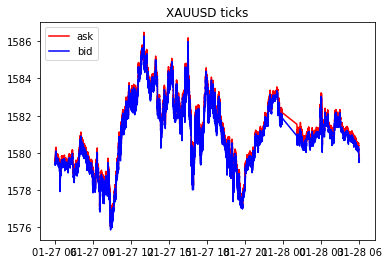

In [3]:
# mndapatkan ticks emas dolar, terdapat bid dan ask
xauusd_ticks = mt5.copy_ticks_range("XAUUSD", datetime(2020,1,27,13), datetime(2020,1,28,13), mt5.COPY_TICKS_ALL)

#rates
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_M1, datetime(2020,1,27,13), datetime(2020,1,28,13))

#memutuskan hubungan
mt5.shutdown()

print('xauusd_ticks(', len(xauusd_ticks), ')')
for val in xauusd_ticks[:10]: print(val)

print('xauusd_rates(', len(xauusd_rates), ')')
for val in xauusd_rates[:10]: print(val)
ticks_frame = pd.DataFrame(xauusd_ticks)

# convert time in seconds into the datetime format
ticks_frame['time']=pd.to_datetime(ticks_frame['time'], unit='s')

#display ticks on the chart
plt.plot(ticks_frame['time'], ticks_frame['ask'], 'r-', label='ask')
plt.plot(ticks_frame['time'], ticks_frame['bid'], 'b-', label='bid')
 
# display the legends
plt.legend(loc='upper left')
 
# add the header
plt.title('XAUUSD ticks')
 
# display the chart
plt.show()

# Objek EDGBOT

In [66]:
class EDGBOT:
    #insiasi
    def __init__(self, bid, ask, country, initDate, endDate):
        self.initDate = initDate
        self.endDate = endDate
        self.country = country
        self.bid = bid
        self.ask = ask
        self.point = 10
        self.gold_constanta = -1
        self.psi = scipy.constants.golden
        #self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.InvTotalISE = 0
        
    def get_event(self): 
        mydata = te.getCalendarData(country = self.country, initDate = self.initDate, endDate = self.endDate, output_type= 'df')
        print(mydata)
        inventory = self.inventory
        for i in range(0, len(mydata)):
           event = mydata['Event'][i]
           amp = mydata['Importance'][i]
           try:
               forecast = float(mydata['Forecast'][i].strip('%').strip('K'))
               print(forecast)
                
           except ValueError:
               forecast = 0 
           try:
               actual = float(mydata["Actual"][i].strip('%').strip('K'))
           except ValueError:
               actual = 0  
           try:
                previous = float(mydata['Previous'][i].strip('%').strip('K'))
           except ValueError:
                previous = 0       
           if forecast == 0 :
               print("forecast = 0")
           elif actual == 0 :
               print("actual = 0")
           elif previous == 0:
               print("previous = 0")
           else:
               percentage_change = ((abs(actual-forecast) + abs(previous-forecast)) / abs(forecast)) * self.get_orientation(actual, forecast)
               inventory.append((event, amp, actual, previous, forecast, percentage_change))
        

    # untuk rumus utama( perkalian SUM dengan konstanta lainnya)
    def counter_result(self):
        Total_ISE = self.intreval_sum_event()
        result = Total_ISE * self.point * self.gold_constanta
        return result

    #rumus mencari (Interval sum of event) dengan rumus sli(sigma dari perkalian
    #traits amplifikasi dan perubahan persen)
    def intreval_sum_event(self):
        inventory = self.inventory
        InvTotalISE = self.InvTotalISE
        traits = 1
        
        
        #looping pada setiap event yang ada
        for i in range(0, len(inventory)):
            event, amp, actual, previous, forecast, percentage_change = inventory[i]
            ISE = traits * amp * percentage_change
            InvTotalISE += ISE
            return InvTotalISE
     
    
    #menghitung orientasi
    def get_orientation(self, current, forecast):
        c = current
        f = forecast       
        if c == f:
            orientation = 0
        elif c > f:
            orientation = 1
        elif c < f:
            orientation = -1            
        return orientation 
    
    #def buy:
        
    #def sell:
        
    #def hold:
        
        
    #def act:
    

In [67]:
EDGBOT = EDGBOT( bid = 1, ask = 1, country = 'United States', initDate = '2017-01-01', endDate = '2018-01-01' )
EDGBOT.get_event()
EDGBOT.counter_result()


  CalendarId                 Date        Country               Category  \
0     124630  2017-01-03T15:00:00  United States    Business Confidence   
1     124629  2017-01-03T14:45:00  United States      Manufacturing PMI   
2     145234  2017-01-03T12:00:00  United States  Mortgage Applications   

                            Event Reference        ReferenceDate  \
0           ISM Manufacturing PMI       Dec  2016-12-31T00:00:00   
1  Markit Manufacturing PMI Final       Dec  2016-12-31T00:00:00   
2       MBA Mortgage Applications    22/Dec  2017-12-22T00:00:00   

                                    Source                        SourceURL  \
0          Institute for Supply Management         https://www.ismworld.org   
1                         Markit Economics  https://www.markiteconomics.com   
2  Mortgage Bankers Association of America  http://www.mortgagebankers.org/   

  Actual  ... TEForecast                                   URL DateSpan  \
0   54.7  ...       53.4    /unite

2.79310344827586